*Source of the case study:* https://8weeksqlchallenge.com/case-study-1/

---

## Case Study #1 - Danny's Diner

**Introduction**
<br>Danny seriously loves Japanese food so in the beginning of 2021, he decides to embark upon a risky venture and opens up a cute little restaurant that sells his 3 favourite foods: sushi, curry and ramen.

Danny’s Diner is in need of your assistance to help the restaurant stay afloat - the restaurant has captured some very basic data from their few months of operation but have no idea how to use their data to help them run the business.

**Problem Statement**
<br>Danny wants to use the data to answer a few simple questions about his customers, especially about their visiting patterns, how much money they’ve spent and also which menu items are their favourite. Having this deeper connection with his customers will help him deliver a better and more personalised experience for his loyal customers.

He plans on using these insights to help him decide whether he should expand the existing customer loyalty program - additionally he needs help to generate some basic datasets so his team can easily inspect the data without needing to use SQL.

Danny has provided you with a sample of his overall customer data due to privacy issues - but he hopes that these examples are enough for you to write fully functioning SQL queries to help him answer his questions!

Danny has shared with you 3 key datasets for this case study:
- `sales` captures all `customer_id` level purchases with an corresponding `order_date` and `product_id` information for when and what menu items were ordered;
- `menu` maps the `product_id` to the actual `product_name` and `price` of each menu item;
- `members` captures the `join_date` when a `customer_id` joined the beta version of the Danny’s Diner loyalty program.

You can inspect the entity relationship diagram and example data below.

**Entity Relationship Diagram**
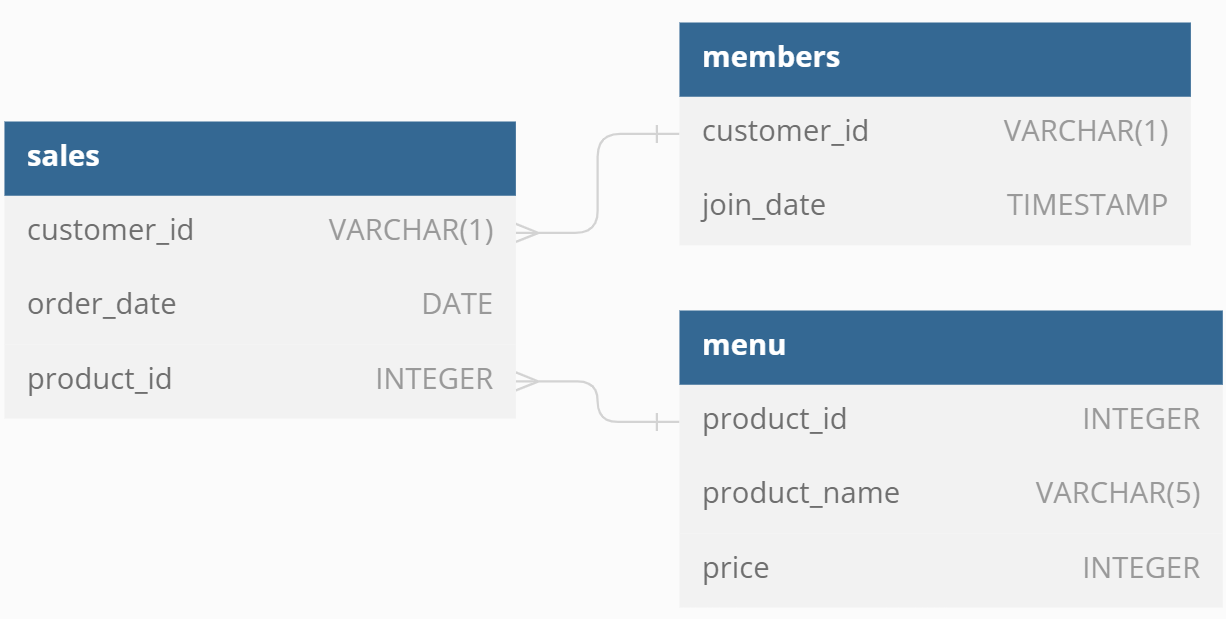

All datasets exist within the `dannys_diner` database schema:

**Schema (PostgreSQL v13)**

    CREATE SCHEMA dannys_diner;
    SET search_path = dannys_diner;
    
    CREATE TABLE sales (
      "customer_id" VARCHAR(1),
      "order_date" DATE,
      "product_id" INTEGER
    );
    
    INSERT INTO sales
      ("customer_id", "order_date", "product_id")
    VALUES
      ('A', '2021-01-01', '1'),
      ('A', '2021-01-01', '2'),
      ('A', '2021-01-07', '2'),
      ('A', '2021-01-10', '3'),
      ('A', '2021-01-11', '3'),
      ('A', '2021-01-11', '3'),
      ('B', '2021-01-01', '2'),
      ('B', '2021-01-02', '2'),
      ('B', '2021-01-04', '1'),
      ('B', '2021-01-11', '1'),
      ('B', '2021-01-16', '3'),
      ('B', '2021-02-01', '3'),
      ('C', '2021-01-01', '3'),
      ('C', '2021-01-01', '3'),
      ('C', '2021-01-07', '3');
     
    
    CREATE TABLE menu (
      "product_id" INTEGER,
      "product_name" VARCHAR(5),
      "price" INTEGER
    );
    
    INSERT INTO menu
      ("product_id", "product_name", "price")
    VALUES
      ('1', 'sushi', '10'),
      ('2', 'curry', '15'),
      ('3', 'ramen', '12');
      
    
    CREATE TABLE members (
      "customer_id" VARCHAR(1),
      "join_date" DATE
    );
    
    INSERT INTO members
      ("customer_id", "join_date")
    VALUES
      ('A', '2021-01-07'),
      ('B', '2021-01-09');
---

**Case Study Questions**

Each of the following case study questions can be answered using a single SQL statement:
1. What is the total amount each customer spent at the restaurant? => [my solution to question 1](#query1)
2. How many days has each customer visited the restaurant? => [my solution to question 2](#query2)
3. What was the first item from the menu purchased by each customer? => [my solution to question 3](#query3)
4. What is the most purchased item on the menu and how many times was it purchased by all customers? => [my solution to question 4](#query4)
5. Which item was the most popular for each customer? => [my solution to question 5](#query5)
6. Which item was purchased first by the customer after they became a member? => [my solution to question 6](#query6)
7. Which item was purchased just before the customer became a member? => [my solution to question 7](#query7)
8. What is the total items and amount spent for each member before they became a member? => [my solution to question 8](#query8)
9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have? => [my solution to question 9](#query9)
10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January? => [my solution to question 10](#query10)

My solution to bonus questions is [here](#bonus).

---

**Query #1**<a id='query1'></a>
<BR>1. What is the total amount each customer spent at the restaurant?

    SELECT s.customer_id, 
           SUM(m.price) AS amount_spent
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    GROUP BY s.customer_id
    ORDER BY 2 DESC;

| customer_id | amount_spent |
| ----------- | ------------ |
| A           | 76           |
| B           | 74           |
| C           | 36           |

---

**Query #2**<a id='query2'></a>
<BR>2. How many days has each customer visited the restaurant?

    SELECT customer_id, 
           COUNT(DISTINCT order_date) AS days_cnt
    FROM dannys_diner.sales
    GROUP BY customer_id
    ORDER BY 2 DESC;

| customer_id | days_cnt |
| ----------- | -------- |
| B           | 6        |
| A           | 4        |
| C           | 2        |

---

**Query #3**<a id='query3'></a>
<BR>3. What was the first item from the menu purchased by each customer?

Since we don't have a timestamp, we don't know exactly what item was purchased earlier assuming multiple items were purchased on the same day. <br>So we decided to include all purchased items on their first purchase date:

    WITH t AS
    (SELECT s.customer_id, m.product_name, 
            RANK() OVER(PARTITION BY s.customer_id ORDER BY s.order_date) AS purchase_day_number
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id)
    
    SELECT t.customer_id, t.product_name
    FROM t
    WHERE t.purchase_day_number = 1
    GROUP BY 1, 2;

| customer_id | product_name |
| ----------- | ------------ |
| A           | curry        |
| A           | sushi        |
| B           | curry        |
| C           | ramen        |

---

**Query #4**<a id='query4'></a>
<br>4. What is the most purchased item on the menu and how many times was it purchased by all customers?

    WITH t AS
    (SELECT m.product_name, 
     		COUNT(s.product_id) AS times_purchased
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    GROUP BY m.product_name)
    
    SELECT *
    FROM t 
    WHERE t.times_purchased = (SELECT MAX(t.times_purchased) FROM t);

| product_name | times_purchased |
| ------------ | --------------- |
| ramen        | 8               |

---

**Query #5**<a id='query5'></a>
<br>5. Which item was the most popular for each customer?

    WITH t AS
    (SELECT s.customer_id,
    	   m.product_name, 
    	   COUNT(s.product_id) AS times_purchased,
           RANK() OVER(PARTITION BY s.customer_id ORDER BY COUNT(s.product_id) DESC) AS popularity_rank
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    GROUP BY s.customer_id, m.product_name)
    
    SELECT customer_id,
    	   product_name, 
    	   times_purchased
    FROM t
    WHERE popularity_rank = 1;

| customer_id | product_name | times_purchased |
| ----------- | ------------ | --------------- |
| A           | ramen        | 3               |
| B           | ramen        | 2               |
| B           | curry        | 2               |
| B           | sushi        | 2               |
| C           | ramen        | 3               |

---

**Query #6**<a id='query6'></a>
<BR>6. Which item was purchased first by the customer after they became a member?

    WITH t AS
    (SELECT s.customer_id, 
    	   m.product_name, 
    	   RANK() OVER(PARTITION BY s.customer_id ORDER BY s.order_date) AS purchase_day_number
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    WHERE s.order_date > b.join_date)
    
    SELECT customer_id,
    	   product_name
    FROM t
    WHERE purchase_day_number = 1;

| customer_id | product_name |
| ----------- | ------------ |
| A           | ramen        |
| B           | sushi        |

---

**Query #7**<a id='query7'></a>
<BR>7. Which item was purchased just before the customer became a member?

    WITH t AS
    (SELECT s.customer_id, 
    	   m.product_name, 
    	   RANK() OVER(PARTITION BY s.customer_id ORDER BY s.order_date DESC) AS purchase_day_number
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    WHERE s.order_date < b.join_date)
    
    SELECT customer_id,
    	   product_name
    FROM t
    WHERE purchase_day_number = 1;

| customer_id | product_name |
| ----------- | ------------ |
| A           | sushi        |
| A           | curry        |
| B           | sushi        |

---

**Query #8**<a id='query8'></a>
<br>8. What is the total items and amount spent for each member before they became a member?

    SELECT s.customer_id, 
    	    COUNT(s.product_id) AS product_cnt,
            SUM(m.price) AS amount_spent
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    WHERE s.order_date < b.join_date
    GROUP BY s.customer_id;

| customer_id | product_cnt | amount_spent |
| ----------- | ----------- | ------------ |
| B           | 3           | 40           |
| A           | 2           | 25           |

---

**Query #9**<a id='query9'></a>
<br>9.  If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

    WITH t AS
    (SELECT s.customer_id, 
    	    m.product_name,
            CASE 
                WHEN m.product_name LIKE 'sushi' THEN SUM(m.price) * 20
                ELSE SUM(m.price) * 10
            END AS points
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    GROUP BY 1, 2)
    
    SELECT customer_id, 
           SUM(points) AS total_points
    FROM t
    GROUP BY 1
    ORDER BY 2 DESC;

| customer_id | total_points |
| ----------- | ------------ |
| B           | 940          |
| A           | 860          |
| C           | 360          |

---

**Query #10**<a id='query10'></a>
<br>10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

    WITH t AS
    (SELECT s.*,
            CASE WHEN s.order_date >= b.join_date 
                      AND s.order_date < (b.join_date + 7) 
                      OR m.product_name ='sushi'
                 THEN 20
                 ELSE 10
            END AS points_coeff,
            m.price
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    WHERE s.customer_id NOT LIKE 'C')
    
    SELECT customer_id, 
           SUM(points_coeff * price) AS total_points
    FROM t
    WHERE order_date < '2021-02-01'
    GROUP BY customer_id;

| customer_id | total_points |
| ----------- | ------------ |
| A           | 1370         |
| B           | 820          |

---

**Bonus Questions**
<a id='bonus'></a>

**1. Join All The Things**

The following questions are related creating basic data tables that Danny and his team can use to quickly derive insights without needing to join the underlying tables using SQL.

Recreate the following table output using the available data:
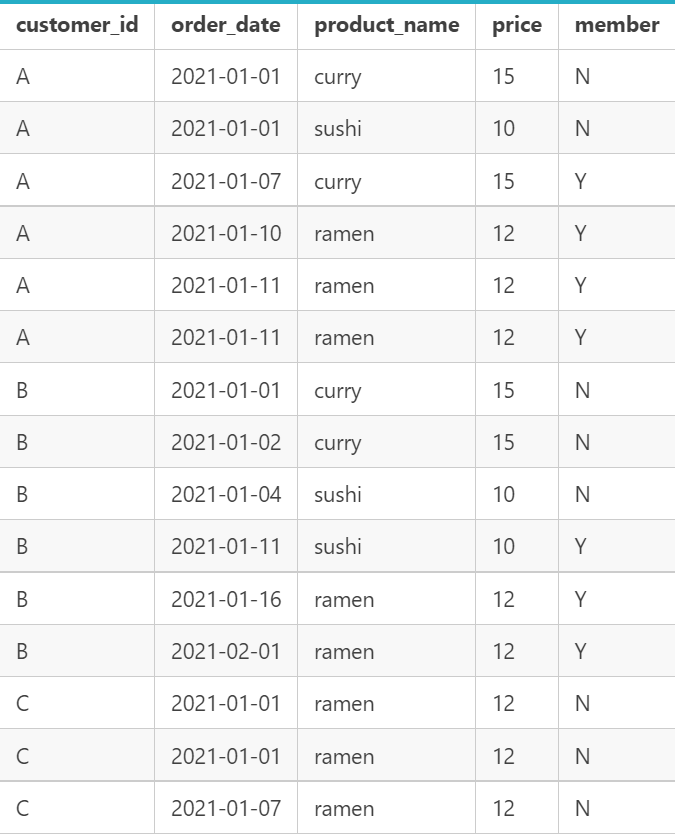

**Query #11**

    SELECT s.customer_id, 
           s.order_date, 
           m.product_name, 
           m.price,
    	   CASE WHEN s.order_date >= b.join_date THEN 'Y'
                ELSE 'N'
           END AS member
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    ORDER BY 1, 2, 3;

| customer_id | order_date               | product_name | price | member |
| ----------- | ------------------------ | ------------ | ----- | ------ |
| A           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |
| A           | 2021-01-01T00:00:00.000Z | sushi        | 10    | N      |
| A           | 2021-01-07T00:00:00.000Z | curry        | 15    | Y      |
| A           | 2021-01-10T00:00:00.000Z | ramen        | 12    | Y      |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      |
| B           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |
| B           | 2021-01-02T00:00:00.000Z | curry        | 15    | N      |
| B           | 2021-01-04T00:00:00.000Z | sushi        | 10    | N      |
| B           | 2021-01-11T00:00:00.000Z | sushi        | 10    | Y      |
| B           | 2021-01-16T00:00:00.000Z | ramen        | 12    | Y      |
| B           | 2021-02-01T00:00:00.000Z | ramen        | 12    | Y      |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |
| C           | 2021-01-07T00:00:00.000Z | ramen        | 12    | N      |

---

**2. Rank All The Things**

Danny also requires further information about the ranking of customer products, but he purposely does not need the ranking for non-member purchases so he expects null ranking values for the records when customers are not yet part of the loyalty program.
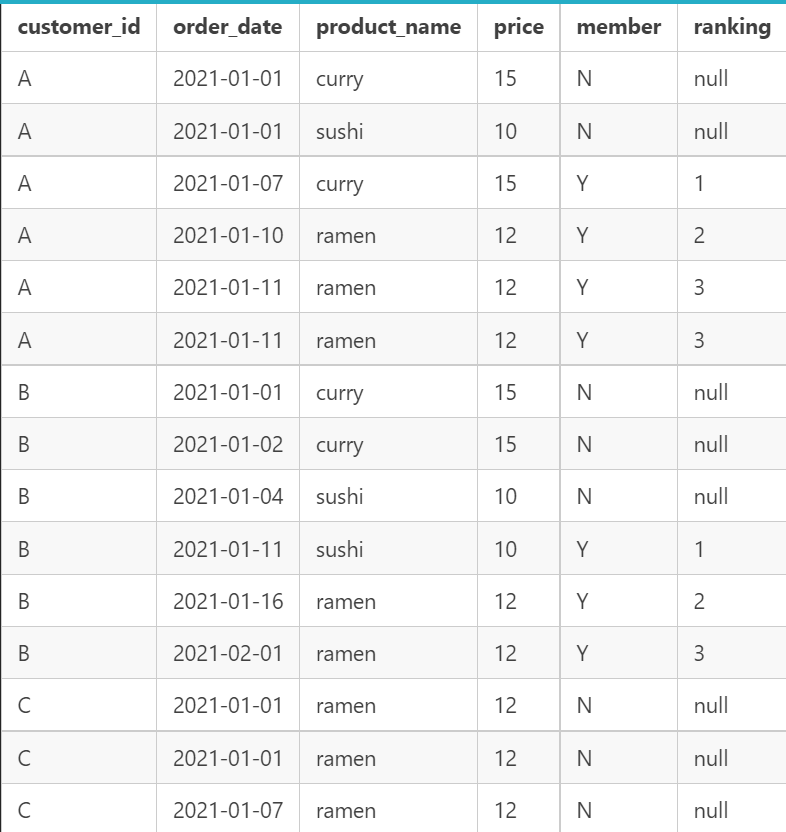

**Query #11**

    WITH t AS
    (SELECT s.customer_id, 
    	   s.order_date, 
           m.product_name, 
           m.price,
    	   CASE WHEN s.order_date >= b.join_date THEN 'Y'
           		ELSE 'N'
           END AS member
    FROM dannys_diner.sales s
    LEFT JOIN dannys_diner.menu m ON s.product_id = m.product_id
    LEFT JOIN dannys_diner.members b ON s.customer_id = b.customer_id
    ORDER BY 1, 2, 3),
    r AS
    (SELECT *,
     	    DENSE_RANK() OVER(PARTITION BY customer_id ORDER BY order_date) AS ranking 
    FROM t
    WHERE member='Y')
    SELECT DISTINCT t.*, r.ranking
    FROM t
    LEFT JOIN r ON t.customer_id = r.customer_id AND t.order_date = r.order_date AND t.product_name = r.product_name AND t.member = r.member;

| customer_id | order_date               | product_name | price | member | ranking |
| ----------- | ------------------------ | ------------ | ----- | ------ | ------- |
| A           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |         |
| A           | 2021-01-01T00:00:00.000Z | sushi        | 10    | N      |         |
| A           | 2021-01-07T00:00:00.000Z | curry        | 15    | Y      | 1       |
| A           | 2021-01-10T00:00:00.000Z | ramen        | 12    | Y      | 2       |
| A           | 2021-01-11T00:00:00.000Z | ramen        | 12    | Y      | 3       |
| B           | 2021-01-01T00:00:00.000Z | curry        | 15    | N      |         |
| B           | 2021-01-02T00:00:00.000Z | curry        | 15    | N      |         |
| B           | 2021-01-04T00:00:00.000Z | sushi        | 10    | N      |         |
| B           | 2021-01-11T00:00:00.000Z | sushi        | 10    | Y      | 1       |
| B           | 2021-01-16T00:00:00.000Z | ramen        | 12    | Y      | 2       |
| B           | 2021-02-01T00:00:00.000Z | ramen        | 12    | Y      | 3       |
| C           | 2021-01-01T00:00:00.000Z | ramen        | 12    | N      |         |
| C           | 2021-01-07T00:00:00.000Z | ramen        | 12    | N      |         |

---

[View on DB Fiddle](https://www.db-fiddle.com/f/2rM8RAnq7h5LLDTzZiRWcd/138)